---
# **Visual Analytics Final Project**
## **A Visual Music Recommender System Powered by Spotify Data**
---
### Members:
- Marina Castellano Blanco NIA 242409
- Júlia Othats-Dalès Gibert NIA 254435


## **1. Libraries**

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import numpy as np

In [14]:
sns.set(style="whitegrid")

## **2. Loading and Merging**

### 2.1. Dataset Spotify Tracks and Artists

In [15]:
data1 = pd.read_csv('data/track_artists/spotify_data1.csv')
data2 = pd.read_csv('data/track_artists/spotify_data2.csv')

# Convertir duración a segundos
if 'track_duration_min' in data1.columns:
    data1['track_duration_sec'] = (data1['track_duration_min'] * 60).round().astype(int)
    data1.drop(columns=['track_duration_min'], inplace=True)

if 'track_duration_ms' in data2.columns:
    data2['track_duration_sec'] = (data2['track_duration_ms'] / 1000).round().astype(int)
    data2.drop(columns=['track_duration_ms'], inplace=True)

# Concatenar datasets
df_spotify = pd.concat([data1, data2], axis=0).reset_index(drop=True)

df_spotify.head()

,track_id,track_name,track_number,track_popularity,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type,track_duration_sec
0,3EJS5LyekDim1Tf5rBFmZl,Trippy Mane (ft. Project Pat),4,0,True,Diplo,77.0,2812821.0,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025-10-31,9,album,93
1,1oQW6G2ZiwMuHqlPpP27DB,OMG!,1,0,True,Yelawolf,64.0,2363438.0,"country hip hop, southern hip hop",4SUmmwnv0xTjRcLdjczGg2,OMG!,2025-10-31,1,single,184
2,7mdkjzoIYlf1rx9EtBpGmU,Hard 2 Find,1,4,True,Riff Raff,48.0,193302.0,NaN,3E3zEAL8gUYWaLYB9L7gbp,Hard 2 Find,2025-10-31,1,single,153
3,67rW0Zl7oB3qEpD5YWWE5w,Still Get Like That (ft. Project Pat & Starrah),8,30,True,Diplo,77.0,2813710.0,moombahton,5QRFnGnBeMGePBKF2xTz5z,"d00mscrvll, Vol. 1",2025-10-31,9,album,101
4,15xptTfRBrjsppW0INUZjf,ride me like a harley,2,0,True,Rumelis,48.0,8682.0,dark r&b,06FDIpSHYmZAZoyuYtc7kd,come closer / ride me like a harley,2025-10-30,2,single,143


### 2.2 Limpieza de nombres de artistas y merge con metadata

In [16]:
artist_meta = pd.read_csv("data/helper/artist_country.csv")
artist_meta['artist_name'] = artist_meta['artist'].str.strip().str.lower()
df_spotify['main_artist_clean'] = df_spotify['artist_name'].str.extract(
    r'^(.*?)(?:\s*\(?\s*(?:ft\.|feat\.|featuring)\s+.*)?$', flags=re.IGNORECASE
)[0].str.strip().str.lower()

df_spotify = df_spotify.merge(
    artist_meta[['artist_name', 'country']],
    left_on='main_artist_clean',
    right_on='artist_name',
    how='left'
)

df_spotify = df_spotify.drop(columns=['main_artist_clean', 'artist_name_y'])
df_spotify = df_spotify.rename(columns={'artist_name_x': 'artist_name'})

# Mostrar las primeras filas del dataframe de metadatos de artistas
artist_meta.head()

,Unnamed: 0,index,artist,gender,age,type,country,city_1,district_1,city_2,district_2,city_3,district_3,artist_name
0,0,0,Drake,male,33,person,CA,NaN,NaN,Toronto,NaN,NaN,NaN,drake
1,1,1,Post Malone,male,25,person,US,NaN,NaN,Syracuse,NaN,NaN,NaN,post malone
2,2,2,Ed Sheeran,male,29,person,GB,NaN,NaN,Halifax,NaN,NaN,NaN,ed sheeran
3,3,3,J Balvin,male,35,person,CO,NaN,NaN,Medellín,NaN,NaN,NaN,j balvin
4,4,4,Bad Bunny,male,26,person,PR,NaN,NaN,San Juan,NaN,NaN,NaN,bad bunny


### 2.3 Dataset Tracks' Audio Features

In [17]:
df_audiofeatures1 = pd.read_csv("data/audio_features/spotify_audio_features1.csv", encoding='latin1')
df_audiofeatures1 = df_audiofeatures1.drop(df_audiofeatures1.columns[0], axis=1) 
df_audiofeatures2 = pd.read_csv("data/audio_features/spotify_audio_features2.csv", encoding='latin1')
df_audiofeatures2 = df_audiofeatures2.drop(df_audiofeatures2.columns[0], axis=1) 

# rename columns to match df_audiofeatures1
df_audiofeatures1 = df_audiofeatures1.rename(columns={
    'Title': 'title',
    'Artist': 'artist',
    'Top Genre': 'top genre',
    'Year': 'year',
    'Beats Per Minute (BPM)': 'bpm',
    'Energy': 'nrgy',
    'Danceability': 'dnce',
    'Loudness (dB)': 'dB',
    'Liveness': 'live',
    'Valence': 'val',
    'Length (Duration)': 'dur',
    'Acousticness': 'acous',
    'Speechiness': 'spch',
    'Popularity': 'pop'
})

df_audiofeatures = pd.concat([df_audiofeatures1, df_audiofeatures2], axis=0).reset_index(drop=True)
df_audiofeatures.head()

# Save final audio features dataframe
df_audiofeatures.to_csv('data/spotify_audio_features.csv', index=False)
df_audiofeatures.to_excel('data/spotify_audio_features.xlsx', index=False)

## **3. Limpieza de datos**

### 3.1. Tracks / Artists Dataset

In [18]:
print("Spotify dataset info:")
df_spotify.info()

# La mayoría son duplicados

Spotify dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17504 entries, 0 to 17503
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_id            17504 non-null  object 
 1   track_name          17502 non-null  object 
 2   track_number        17504 non-null  int64  
 3   track_popularity    17504 non-null  int64  
 4   explicit            17504 non-null  bool   
 5   artist_name         17497 non-null  object 
 6   artist_popularity   17500 non-null  float64
 7   artist_followers    17500 non-null  float64
 8   artist_genres       14122 non-null  object 
 9   album_id            17504 non-null  object 
 10  album_name          17502 non-null  object 
 11  album_release_date  17504 non-null  object 
 12  album_total_tracks  17504 non-null  int64  
 13  album_type          17504 non-null  object 
 14  track_duration_sec  17504 non-null  int64  
 15  country             9717 non-nu

In [19]:
print(f"Tamaño inicial del dataset: {df_spotify.shape}")

print("\nValores faltantes por columna:")
print(df_spotify.isna().sum())
df_spotify = df_spotify.dropna(subset=['artist_name', 'artist_popularity', 'track_name', 'artist_followers', 'album_name'])
print(f"\nEliminando filas con valores faltantes en columnas clave. Nuevo tamaño del dataset: {df_spotify.shape}")

Tamaño inicial del dataset: (17504, 16)

Valores faltantes por columna:
track_id                 0
track_name               2
track_number             0
track_popularity         0
explicit                 0
artist_name              7
artist_popularity        4
artist_followers         4
artist_genres         3382
album_id                 0
album_name               2
album_release_date       0
album_total_tracks       0
album_type               0
track_duration_sec       0
country               7787
dtype: int64

Eliminando filas con valores faltantes en columnas clave. Nuevo tamaño del dataset: (17495, 16)


In [20]:
print(f"\nEliminando {df_spotify.duplicated(subset=['track_name','artist_name']).sum()} duplicados de canciones...")
df_spotify = df_spotify.drop_duplicates(subset=['track_name','artist_name'], keep='last')
print(f"\nNuevo tamaño del dataset después de eliminar duplicados: {df_spotify.shape}")


Eliminando 9455 duplicados de canciones...

Nuevo tamaño del dataset después de eliminar duplicados: (8040, 16)


In [ ]:
# Procesar fechas de lanzamiento
df_spotify['album_release_date'] = pd.to_datetime(df_spotify['album_release_date'], errors='coerce')
df_spotify['release_year'] = df_spotify['album_release_date'].dt.year
df_spotify['release_month'] = df_spotify['album_release_date'].dt.month

In [ ]:
# Save final spotify dataframe
df_spotify.to_csv('data/spotify_tracks_artists.csv', index=False)
df_spotify.to_excel('data/tableau/spotify_tracks_artists.xlsx', index=False)

### 3.2. Audio Features Dataset

In [22]:
print("\nAudio Features dataset info:")
df_audiofeatures.info()


Audio Features dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2597 entries, 0 to 2596
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      2597 non-null   object
 1   artist     2597 non-null   object
 2   top genre  2597 non-null   object
 3   year       2597 non-null   int64 
 4   bpm        2597 non-null   int64 
 5   nrgy       2597 non-null   int64 
 6   dnce       2597 non-null   int64 
 7   dB         2597 non-null   int64 
 8   live       2597 non-null   int64 
 9   val        2597 non-null   int64 
 10  dur        2597 non-null   object
 11  acous      2597 non-null   int64 
 12  spch       2597 non-null   int64 
 13  pop        2597 non-null   int64 
dtypes: int64(10), object(4)
memory usage: 284.2+ KB


In [24]:
print("\nValores faltantes por columna:")
print(df_audiofeatures.isna().sum())


Valores faltantes por columna:
title        0
artist       0
top genre    0
year         0
bpm          0
nrgy         0
dnce         0
dB           0
live         0
val          0
dur          0
acous        0
spch         0
pop          0
dtype: int64


In [25]:
print("Valores duplicados en audio features dataset:", df_audiofeatures.duplicated().sum())

Valores duplicados en audio features dataset: 0


In [ ]:
# Save final audio features dataframe
df_audiofeatures.to_csv('data/spotify_audio_features.csv', index=False)
df_audiofeatures.to_excel('data/tableau/spotify_audio_features.xlsx', index=False)

## **4. Exploratory Data Analysis**

### 4.1. Basic Statistics

In [27]:
print("Descripción numérica Spotify:")
display(df_spotify.describe())
print("Descripción categórica Spotify:")
display(df_spotify.describe(include="O"))

Descripción numérica Spotify:


,track_number,track_popularity,artist_popularity,artist_followers,album_release_date,album_total_tracks,track_duration_sec,release_year,release_month
count,8040.000000,8040.000000,8040.000000,8.040000e+03,7855,8040.000000,8040.000000,7855.000000,7855.000000
mean,5.808955,51.679229,68.594776,2.203544e+07,2015-11-11 13:55:57.097390336,13.808458,208.842537,2015.371483,6.438320
min,1.000000,0.000000,0.000000,0.000000e+00,1952-09-12 00:00:00,1.000000,4.000000,1952.000000,1.000000
25%,1.000000,38.000000,58.000000,3.443340e+05,2012-09-28 00:00:00,6.000000,171.000000,2012.000000,3.000000
50%,4.000000,57.000000,73.000000,5.042529e+06,2018-05-11 00:00:00,13.000000,205.500000,2018.000000,7.000000
75%,9.000000,70.000000,83.000000,2.576170e+07,2022-09-03 12:00:00,17.000000,239.000000,2022.000000,10.000000
max,102.000000,100.000000,100.000000,1.455421e+08,2025-10-31 00:00:00,181.000000,811.000000,2025.000000,12.000000
std,6.074880,23.600617,19.802093,3.628336e+07,NaN,12.077841,64.973066,9.727494,3.506113


Descripción categórica Spotify:


,track_id,track_name,artist_name,artist_genres,album_id,album_name,album_type,country
count,8040,8040,8040,7994,8040,8040,8040,4238
unique,7928,7579,2548,675,4879,4659,3,34
top,6wf7Yu7cxBSPrRlWeSeK0Q,Ghost,Taylor Swift,[],3FFGbUutKWN1c4f0CJR4Uh,Nevermind (Super Deluxe Edition),album,US
freq,2,7,246,3940,70,70,5427,2613


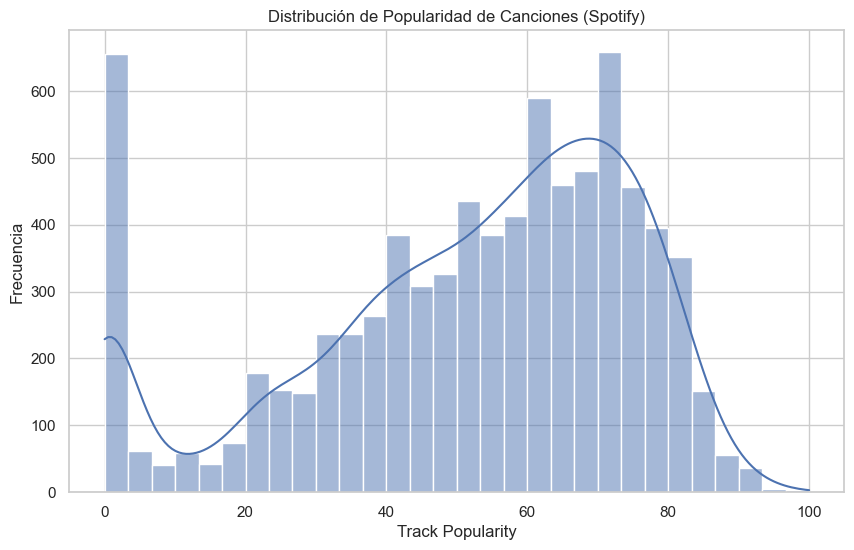

In [28]:
# Distribución de popularidad de tracks
plt.figure(figsize=(10,6))
sns.histplot(df_spotify['track_popularity'], bins=30, kde=True)
plt.title('Distribución de Popularidad de Canciones (Spotify)')
plt.xlabel('Track Popularity')
plt.ylabel('Frecuencia')
plt.show()

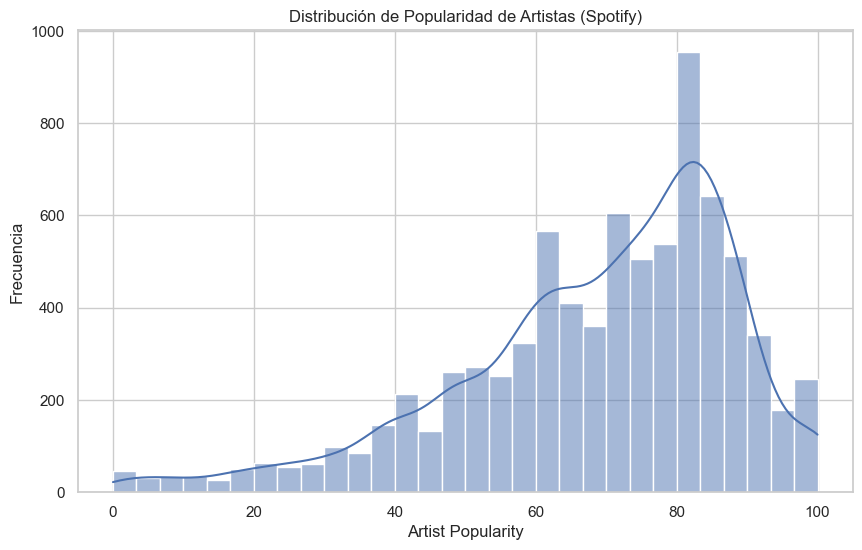

In [29]:
# Distribución de popularidad de artistas
plt.figure(figsize=(10,6))
sns.histplot(df_spotify['artist_popularity'], bins=30, kde=True)
plt.title('Distribución de Popularidad de Artistas (Spotify)')
plt.xlabel('Artist Popularity')
plt.ylabel('Frecuencia')
plt.show()

In [30]:
# Top 10 tracks y artistas
top10_tracks = df_spotify.sort_values(by='track_popularity', ascending=False).head(10)
top10_artists = df_spotify.drop_duplicates(subset='artist_name').sort_values(by='artist_popularity', ascending=False).head(10)

print("Top 10 Tracks (Spotify):")
display(top10_tracks[['track_name','artist_name','track_popularity']])
print("\nTop 10 Artists (Spotify):")
display(top10_artists[['artist_name','artist_popularity','artist_followers']])


Top 10 Tracks (Spotify):


,track_name,artist_name,track_popularity
15804,The Fate of Ophelia,Taylor Swift,100
13066,Golden,HUNTR/X,99
14195,Opalite,Taylor Swift,97
12325,Man I Need,Olivia Dean,95
15157,Elizabeth Taylor,Taylor Swift,95
10060,BIRDS OF A FEATHER,Billie Eilish,94
17383,Father Figure,Taylor Swift,94
11811,Soda Pop,Saja Boys,94
14749,Wood,Taylor Swift,93
10534,How It’s Done,HUNTR/X,93



Top 10 Artists (Spotify):


,artist_name,artist_popularity,artist_followers
1496,Taylor Swift,100.0,145396321.0
8800,Drake,95.0,103039388.0
8697,Bad Bunny,95.0,102500980.0
5617,The Weeknd,94.0,112995439.0
8726,Justin Bieber,91.0,85008100.0
9088,Sabrina Carpenter,91.0,26516295.0
5546,Rihanna,90.0,68997177.0
8686,Ariana Grande,90.0,107374593.0
1705,Billie Eilish,90.0,118692183.0
9233,Kanye West,89.0,31038851.0
